# Model Development

In [1]:
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.compose import TransformedTargetRegressor

In [3]:
df_hour = pd.read_csv("hour.csv")

## Feature Engineering

### Preliminary selection of model features

In [4]:
preliminary_features = ["season","mnth","hr","holiday","weekday","workingday","weathersit","temp","hum","windspeed","cnt"]
df = df_hour[preliminary_features]

### Encoding categorical variables 

In [5]:
def one_hot_encode(df,categorical2encode):
    for cat_var in categorical2encode:
        df = pd.concat([df,pd.get_dummies(df[cat_var],prefix=cat_var)], axis=1)
        df.drop(columns=cat_var,inplace=True)
    print("Number of model features after one-hot encoding: {}".format(len(df.columns)-1))
    return df

categorical2encode = ["season","mnth","hr","weekday","weathersit"]
df = one_hot_encode(df,categorical2encode)

Number of model features after one-hot encoding: 56


### Scaling numerical Features

The numerical features "temp", "windspeed", "hum" are already scaled (and normalized) within an interval \[0,1\]. Therefore, no scaling is needed for them.

## Train - test split of dataset 

Given the time-series nature of the problem, instead of a random split of observations for the test and the train sets,  I will reserve a fraction of the data at the very end as a **test set** to evaluate the model error. The rest will be used for **training and cross-validation**.

In [6]:
def split_train_test(df,fraction_train=0.8):
    train_set = df.loc[ : int(fraction_train*len(df)) -1]
    test_set =  df.loc[ int(fraction_train*len(df)) : ]
    y_train = train_set.pop("cnt")
    X_train = train_set
    y_test = test_set.pop("cnt")
    X_test = test_set
    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = split_train_test(df,fraction_train=0.8)

<IPython.core.display.Javascript object>


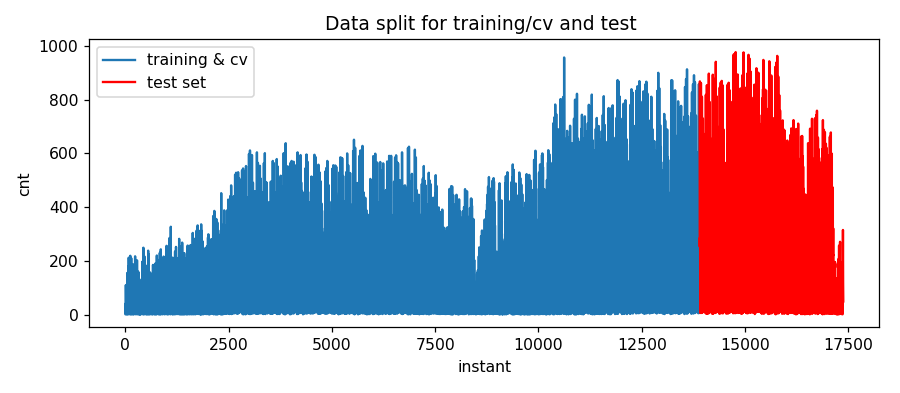

In [8]:
plt.figure(figsize=(8,3.5))
ax1 = sns.lineplot(data=y_train, label="training & cv")
sns.lineplot(data=y_test, label="test set",ax=ax1,color="r")
plt.gca().set(title="Data split for training/cv and test ",xlabel="instant",ylabel="cnt")
plt.tight_layout()

## Model Training & Cross-validation 

- R2 score as evaluation  metric (regression problem).
- Learning algorith implemented: Linear regression with combined L1 and L2 regularization (`ElasticNet`).

### Time-series cross-validation
The goal of a time-series model is conduct prediction on future events. Therefore, a k-fold cross validation with **random** split of the data is not the most appropiate for this problem, because it ignores the temporal order. Instead, I will use a time-ordered split (*forward-chaining validation*) via the `TimeSeriesSplit` scikit-learn class

In [9]:
n_splits=5
tscv = TimeSeriesSplit(n_splits=n_splits)

<IPython.core.display.Javascript object>


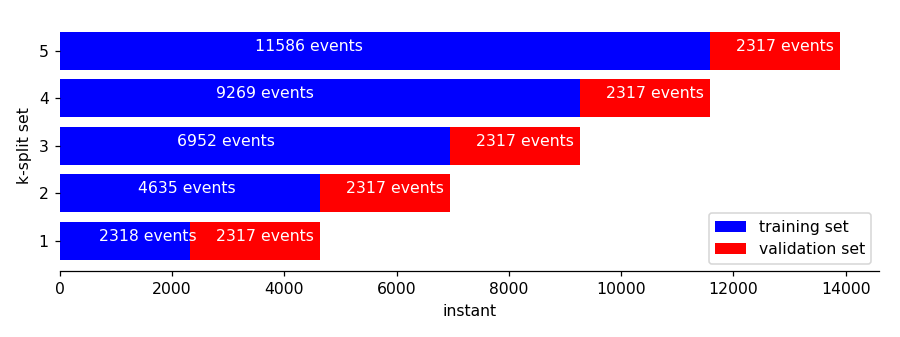

In [10]:
# Plot to visualize k-fold data split for training and cross-validation
plt.figure(figsize=(8,0.6*n_splits))
label_t = ["training set"] + [None for i in range(n_splits-1)]
label_cv = ["validation set"] + [None for i in range(n_splits-1)]
for fold, (train_index, cv_index) in enumerate(tscv.split(X_train)):
    len_t =len(train_index)
    len_cv = len(cv_index)
    plt.barh(y=fold+1,width=len_t,color="blue",label=label_t[fold])
    plt.barh(y=fold+1,width=len_cv,left=len_t,color="red",label=label_cv[fold])
    plt.annotate(s="{} events".format(len_t),xy=(0.3*len_t, fold+1),color="white")
    plt.annotate(s="{} events".format(len_cv),xy=(len_t+0.2*len_cv, fold+1),color="white")
plt.gca().set(xlabel="instant",ylabel="k-split set", yticks = [i for i in range(1,n_splits+1)] )
plt.legend(loc="lower right")
sns.despine(left=True)
plt.tight_layout()
plt.savefig("./report/kfold_time_ordered_splits.png",format='png')

### GridSearch & sub-space of hyper-parameters

In [11]:
model = ElasticNet(max_iter=3000,tol=1e-5)
#sub-space of hyper-parameters explored: 
parameters = {'alpha':[1e-3,5e-3,1e-2,5e-2,1e-1,1,5], 'l1_ratio':[0.05,0.25,0.5,0.75,1.0]}

In [12]:
clf = GridSearchCV(model, parameters, cv=tscv,scoring="r2",n_jobs=-1)
%time clf.fit(X_train,y_train)

Wall time: 19 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-05, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5], 'l1_ratio': [0.05, 0.25, 0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [13]:
def plot_cross_validation_results(parameters,grid_search,saveplot=""):
    n = len(parameters)
    fig, _ = plt.subplots(n-1,n-1,figsize=(1.8*n,1.8*n),sharex='col',sharey='row')    
    hyper_param = [i.split("__")[-1] for i in parameters.keys()]    
    cv_res = pd.DataFrame(grid_search.cv_results_)
    name_formater = lambda i: 'param_'+ list(parameters.keys())[i]
    
    for i in range(n):
        for j in range(n):
            if j>=i: continue
            # choose between split5_test_score or mean_test_score to display
            cv_pvt = pd.pivot_table(cv_res, values='split4_test_score',index= name_formater(i), columns=name_formater(j))
            z = (i-1)*(n-1) + (j+1)
            ax = plt.subplot(n-1,n-1,z)
            sns.heatmap(cv_pvt,annot=True,cbar=False,vmin=-1,vmax=1.0,cmap="cividis",linewidths=.005)
            if i<n-1: ax.get_xaxis().set_visible(False)
            else: ax.set_xlabel(hyper_param[j])
            if j>0: ax.get_yaxis().set_visible(False)
            else: ax.set_ylabel(hyper_param[i])
    plt.subplots_adjust(left=.06,right=.97,top=0.95,bottom=0.11,wspace=0.04,hspace=0.04)
    plt.tight_layout()  
    if saveplot !="":
        plt.savefig("./report/cv_{}.png".format(saveplot),format='png')
    return

{'alpha': 0.001, 'l1_ratio': 1.0}


<IPython.core.display.Javascript object>


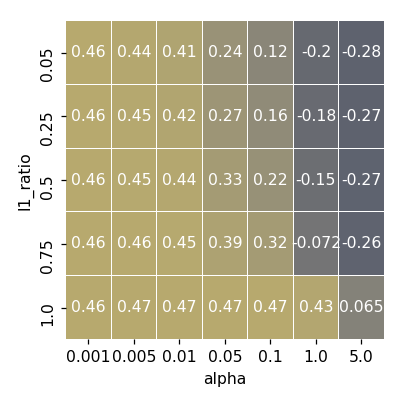

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split3_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set

In [14]:
print(clf.best_params_)
plot_cross_validation_results(parameters,clf,"target-cnt")

### Engineering additional features: Aggregates from previous instants:

Feature based on target-related information from observations near in the past are added:  
- "3h": Av. counts in the previous 3 hours
- "1week": Av. counts in the previous week 

**The current “cnt” was excluded to prevent leaking the target itself as feature**.  
The features were scaled using a `MinMaxScaler`, with parameters fixed using only the training set

In [15]:
def aggregate_last_n_hours(instant,n_hours):
    agg = 0
    for i in range(1,n_hours+1):
        if (instant-i <=0) or not(instant - i in df_hour.index):
            agg =+ df_hour["cnt"].mean()
        else:
            #The cnt of the instant IS EXCLUDED (.loc[instant-1-i]). That is important to avoid data leakeage
            current_index = instant-1
            agg =+df_hour["cnt"].loc[ current_index - i ]
    return agg/n_hours

In [16]:
names = []
for i,name in [ (3,"3h") ,(24*7,"1w")]:
    %%time df_hour[name]= df_hour["instant"].apply(lambda x: aggregate_last_n_hours(x,i)  )
    names.append(name)

df_hour[names].head(6)

Wall time: 1.55 s
Wall time: 1min 33s


,3h,1w
0,63.154363,1.127756
1,63.154363,1.127756
2,63.154363,1.127756
3,5.333333,1.127756
4,13.333333,1.127756
5,10.666667,1.127756


In [17]:
df = df_hour[ preliminary_features + names ]
df = one_hot_encode(df,categorical2encode)
X_train, y_train, X_test, y_test = split_train_test(df,fraction_train=0.8)

Number of model features after one-hot encoding: 58


In [18]:
# scalers are fitted only using training data. test data not used to avoide leakage 
scalers = {}
for name in ["3h","1w"]:
    scaler = MinMaxScaler()
    feature_name = name+"_scaled"
    X_train[feature_name]=scaler.fit_transform( X_train[name].values.reshape(-1, 1) )   
    X_train.drop(columns=name,inplace=True)
    scalers[name] = scaler

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [19]:
clf_agg = GridSearchCV(model, parameters, cv=tscv,scoring="r2",n_jobs=-1)
%time clf_agg.fit(X_train,y_train)
print(clf_agg.best_params_)

Wall time: 22.9 s
{'alpha': 0.001, 'l1_ratio': 1.0}


c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


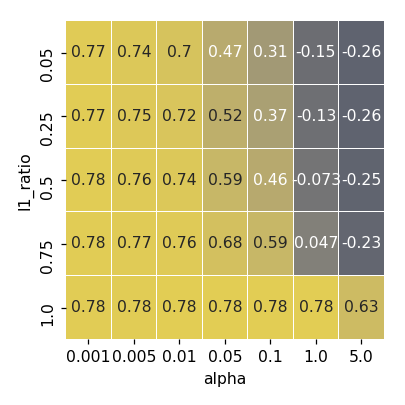

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split3_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set

In [20]:
plot_cross_validation_results(parameters,clf_agg,"target-cnt_addfea-3h1w")

### Exploring the effect of log-transformation of target and removal of outliers

In [21]:
### log-transformation of target
regr_trans = TransformedTargetRegressor(regressor=ElasticNet(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
parameters_logtarget = {'regressor__alpha':parameters["alpha"], 'regressor__l1_ratio': parameters["l1_ratio"]}
clf_logtarget = GridSearchCV(regr_trans, parameters_logtarget, cv=tscv,scoring="r2",n_jobs=-1)
%time clf_logtarget.fit(X_train,y_train)

Wall time: 4.19 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log1p'>,
              inverse_func=<ufunc 'expm1'>,
              regressor=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
              transformer=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5], 'regressor__l1_ratio': [0.05, 0.25, 0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

<IPython.core.display.Javascript object>


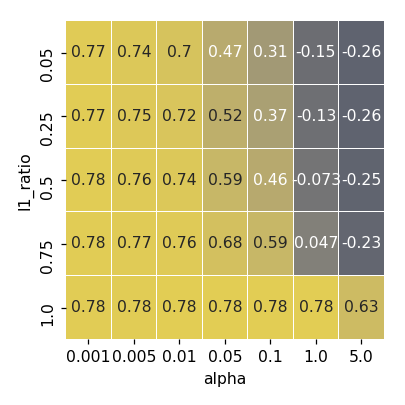

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split3_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set

In [22]:
plot_cross_validation_results(parameters,clf_agg,"target-logcnt_addfea-3h1w")

In [23]:
### outliers removal for training

X_train_no_outl, y_train_no_outl = X_train.copy(), y_train.copy()

for var in ["cnt","temp","hum","windspeed","3h_scaled","1w_scaled"]:
    threshold = 3.3
    if var=="cnt":
        z = stats.zscore( y_train_no_outl )
        index_outliers_zscore = np.where(z > threshold)
        outliers_zscore = y_train_no_outl.iloc[ index_outliers_zscore ]
    else:
        z = stats.zscore( X_train_no_outl[var] )
        index_outliers_zscore = np.where(z > threshold)
        outliers_zscore = X_train_no_outl[var].iloc[ index_outliers_zscore ]
    X_train_no_outl.drop(index= outliers_zscore.index,inplace=True)
    y_train_no_outl.drop(index= outliers_zscore.index,inplace=True)
    print("{} outliers removed for '{}' ({:0.2f} % of training set)".format( len(outliers_zscore),var, 100*len(outliers_zscore)/len(X_train)  ))

116 outliers removed for 'cnt' (0.83 % of training set)
0 outliers removed for 'temp' (0.00 % of training set)
0 outliers removed for 'hum' (0.00 % of training set)
55 outliers removed for 'windspeed' (0.40 % of training set)
116 outliers removed for '3h_scaled' (0.83 % of training set)
80 outliers removed for '1w_scaled' (0.58 % of training set)


In [24]:
clf_no_outl = GridSearchCV(model, parameters, cv=tscv,scoring="r2",n_jobs=-1)
%time clf_no_outl.fit(X_train_no_outl,y_train_no_outl)

Wall time: 19.4 s


c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-05, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5], 'l1_ratio': [0.05, 0.25, 0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

<IPython.core.display.Javascript object>


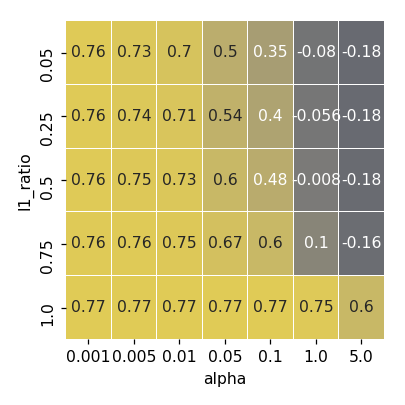

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split3_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set

In [25]:
plot_cross_validation_results(parameters,clf_no_outl,"target-cnt_addfea-3h1w_noOutliers")

### Residuals for previous models

In [26]:
def plot_residuals(y_true,y_pred, saveplot=""):
    plt.figure(figsize=(9,5.5))
    for i in y_pred.keys():
        label = "{}: ".format(i)+r'$R^2$=%.2f, $MAE$=%.2f' % ( r2_score(y_true.values, y_pred[i]), 
                                                              median_absolute_error(y_true.values, y_pred[i]))
        residuals = y_true.values - y_pred[i]
        sns.scatterplot(x=y_true,y=residuals,label=label,size=0.2,alpha=0.3)
    ax1=plt.gca()
    ax1.plot([1000, 0], [0,0], '--k')
    ax1.set( ylabel='Residuals (= True - Predicted)', xlabel='cnt', ylim=(-850,650),xlim=(-10,950))
    handles, labels = ax1.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if i%5==0]
    ax1.legend(*zip(*unique), ncol=1, loc="lower left", frameon=True,framealpha=1.0)
    ax1.grid(axis="y",linestyle='--', linewidth=1.0)
    plt.tight_layout()
    if saveplot !="":
        plt.savefig("./report/{}.png".format(saveplot),format='png')
    return

<IPython.core.display.Javascript object>


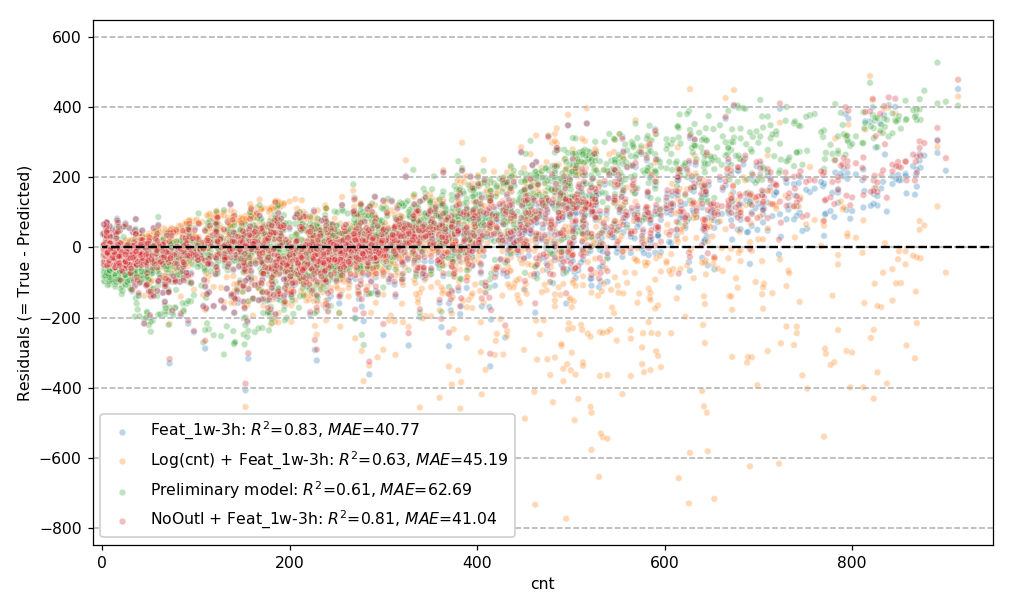

In [27]:
 for fold, (train_index, cv_index) in enumerate(tscv.split(X_train)):
    if fold == n_splits-1:
        X_valid  = X_train.iloc[cv_index]
        y_valid  = X_train.iloc[cv_index]
        y_true   = y_train.iloc[cv_index]
predictions = {}
predictions["Preliminary model"] = clf.predict(X_valid.drop(columns=["1w_scaled","3h_scaled"]))
predictions["Feat_1w-3h"]= clf_agg.predict(X_valid)
predictions["Log(cnt) + Feat_1w-3h"]= clf_logtarget.predict(X_valid)
predictions["NoOutl + Feat_1w-3h"]= clf_no_outl.predict(X_valid)
plot_residuals(y_true,predictions,"residuals_different_models")